In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.8.0


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-50-1500-splits/train"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Testing set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60058 files belonging to 50 classes.
Using 48047 files for training.
Found 60058 files belonging to 50 classes.
Using 12011 files for validation.


In [55]:
def img_transforms(data,label):
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE

train_ds_preprocessed = train_ds.map(img_transforms)#,num_parallel_calls=AUTOTUNE)
val_ds_preprocessed = val_ds.map(img_transforms)#,num_parallel_calls=AUTOTUNE)

# CASHE_Train = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-50-1500-splits/CASHE_Train_50_1500"
# CASHE_Val = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-50-1500-splits/CASHE_Val_50_1500"
# train_ds_preprocessed = train_ds_preprocessed.cache(CASHE_Train).prefetch(buffer_size=AUTOTUNE)
# val_ds_preprocessed = val_ds_preprocessed.cache(CASHE_Val).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Used to create CASHE in local disk
idx = 0
start_time = time.time()
for t in train_ds_preprocessed:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

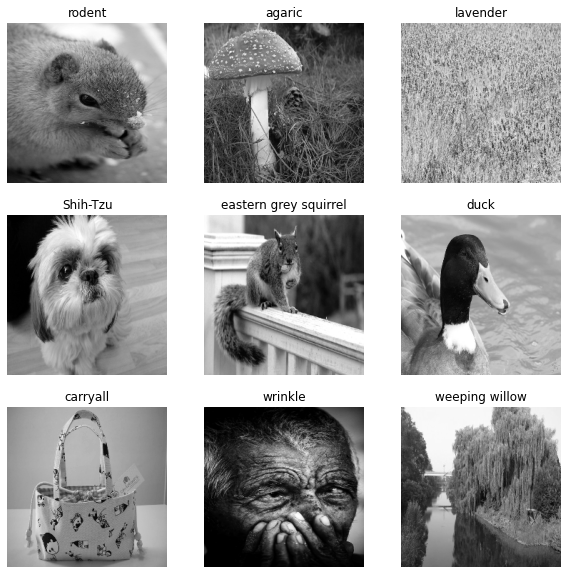

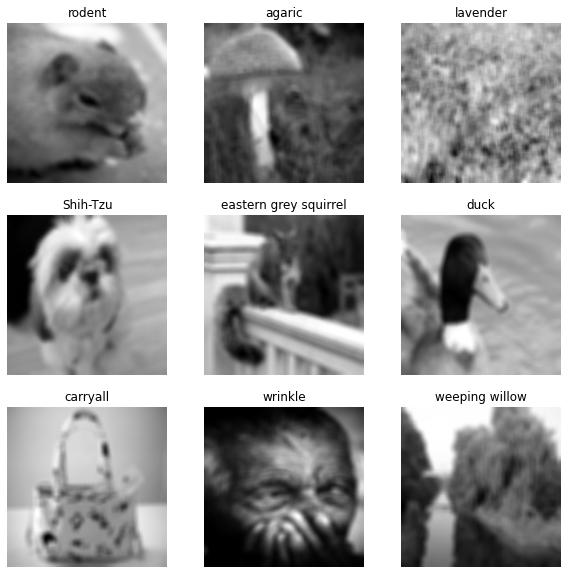

In [54]:
#Visualizing gray images and other effects
np.random.seed(0)

def img_transforms_no_blur(data,label):
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

val_ds_preprocessed_no_blur = val_ds.map(img_transforms_no_blur)

class_names = train_ds.class_names
gray_imgs = []
plt.figure(figsize=(10, 10))
for images, labels in val_ds_preprocessed_no_blur.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,-1],cmap="gray")
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(gray_imgs):
      ax = plt.subplot(3, 3, i + 1)
      blurred_img = tfa.image.gaussian_filter2d(images[:,:,-1:],filter_shape=(10,10),sigma=5.0)
      plt.imshow(blurred_img.numpy().squeeze(),cmap="gray")
      plt.title(class_names[labels])
      plt.axis("off")

### Dual Stream ResNet Architecture

In [5]:
from keras.backend import dropout
class DualStream_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None, 
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.magno_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        
        self.parvo_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.magno_stream.trainable = False
          self.parvo_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(2048,activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)
        
        p_stream = self.parvo_stream(concat_gray_input)
        p_stream = self.flat(p_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([p_stream,m_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([p_stream,m_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

In [8]:
FREEZE = False 
LOAD_WEIGHTS = None #One of None or imagenet
dual_stream_model = DualStream_ResNet(50,batch_size,FREEZE,load_type=LOAD_WEIGHTS,
                                      merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [9]:
# checkpoint_path = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models//content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_ResNet2.0"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 4)
model_save_loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/"
model_name = "Dualstream_with_ResNet_1000_Samples_Deeper_50Classes"
dual_stream_model.save(f"{model_save_loc}{model_name}")

#Save training history to CSV
hist_df = pd.DataFrame(train_history.history)

hist_csv_file = f"{model_save_loc}{model_name}_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plt.figure()
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/30


InvalidArgumentError: ignored

In [ ]:
#Load Model:
dual_stream_model = tf.keras.models.load_model("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Dualstream_with_ResNet_1000_Samples_Deeper")
# dual_stream_model.layers[0].summary()
eval_loss, eval_accuracy = dual_stream_model.evaluate(val_ds_preprocessed)


In [40]:
dual_stream_model.history.history.keys()

dict_keys([])

### Simple ResNet architectur test

In [14]:
#Testing Pure ResNet Model Training
from keras.backend import dropout
class Single_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None, 
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.magno_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.magno_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([#tf.keras.layers.Dense(2048,activation='ReLU'),
                              #tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)

        return self.fc(m_stream)

In [15]:
FREEZE = False 
LOAD_WEIGHTS = None #One of None or imagenet
signle_resnet_model = Single_ResNet(10,batch_size,FREEZE,load_type=LOAD_WEIGHTS,
                                      merge_type="averaging")
signle_resnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

train_history = signle_resnet_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 4)
signle_resnet_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper")

Epoch 1/30
291/291 [==============================] - 72s 227ms/step - loss: 13.6862 - accuracy: 0.1110 - val_loss: 2.3041 - val_accuracy: 0.1156
Epoch 2/30
291/291 [==============================] - 64s 219ms/step - loss: 2.2606 - accuracy: 0.1448 - val_loss: 2.2146 - val_accuracy: 0.1586
Epoch 3/30
291/291 [==============================] - 64s 219ms/step - loss: 2.2257 - accuracy: 0.1625 - val_loss: 2.1758 - val_accuracy: 0.1844
Epoch 4/30
291/291 [==============================] - 63s 216ms/step - loss: 2.1793 - accuracy: 0.1795 - val_loss: 2.1855 - val_accuracy: 0.1624
Epoch 5/30
291/291 [==============================] - 64s 220ms/step - loss: 2.1579 - accuracy: 0.1872 - val_loss: 2.0857 - val_accuracy: 0.1990
Epoch 6/30
291/291 [==============================] - 64s 220ms/step - loss: 2.1143 - accuracy: 0.2057 - val_loss: 2.0430 - val_accuracy: 0.2119
Epoch 7/30
291/291 [==============================] - 64s 219ms/step - loss: 2.0276 - accuracy: 0.2475 - val_loss: 1.8438 - val_a

INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper/assets


### DualStream with VGG versions

### DualStream EfficientNet Architecture
(limitation: it overfits really badly on our current dataset. The literature reports overfitting when smaller training sets are given as a serious issue with EffectiveNet)

In [ ]:
import tensorflow as tf
                                                                                
class DualStream_ENet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None,
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.magno_stream = tf.keras.applications.EfficientNetB0(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=self.n_outputs,
                            classifier_activation="softmax",
                            )
        
        self.parvo_stream = tf.keras.applications.EfficientNetB0(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=self.n_outputs,
                            classifier_activation="softmax",
                            )
        if freeze:
          self.magno_stream.trainable = False
          self.parvo_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(2048,activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()
        self.fc_out = tf.keras.layers.Dense(self.n_outputs, activation='softmax')

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        # start_time = time.time()
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)
        # print("delta_time:",time.time()-start_time)

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)
        
        p_stream = self.parvo_stream(concat_gray_input)
        p_stream = self.flat(p_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([p_stream,m_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([p_stream,m_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

In [ ]:
FREEZE = False #One of None or imagenet
dual_stream_model = DualStream_ENet(50,batch_size,FREEZE,load_type="imagenet",
                                    merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# checkpoint_path = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models//content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_ResNet2.0"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 4)
dual_stream_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_EfficientNet_Deeper")

Epoch 1/30
489/489 [==============================] - 348s 671ms/step - loss: 2.9101 - accuracy: 0.3179 - val_loss: 5.7237 - val_accuracy: 0.0133
Epoch 2/30
489/489 [==============================] - 325s 663ms/step - loss: 2.3374 - accuracy: 0.4244 - val_loss: 19.3927 - val_accuracy: 0.0190
Epoch 3/30
489/489 [==============================] - 325s 663ms/step - loss: 2.2102 - accuracy: 0.4646 - val_loss: 44.7883 - val_accuracy: 0.0207
Epoch 4/30
489/489 [==============================] - 325s 664ms/step - loss: 2.2732 - accuracy: 0.4535 - val_loss: 13.0702 - val_accuracy: 0.0228
Epoch 5/30
489/489 [==============================] - 324s 662ms/step - loss: 2.1662 - accuracy: 0.4679 - val_loss: 4.0507 - val_accuracy: 0.0251
Epoch 6/30
489/489 [==============================] - 324s 661ms/step - loss: 2.1699 - accuracy: 0.4697 - val_loss: 136.9688 - val_accuracy: 0.0182
Epoch 7/30
489/489 [==============================] - 324s 662ms/step - loss: 2.3259 - accuracy: 0.4434 - val_loss: 5.0

### Exploring different types of architecture:

In [ ]:
#VGG architecture with no pre-loaded weights

out_classes = 10

Magno_VGG_16 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten()
])

Parvo_VGG_8 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten()
])

fc_end = Sequential([
    Average(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=out_classes, activation="softmax")
])